<a href="https://colab.research.google.com/github/akulaakshaya/FinalYear/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)     

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Data Directory
# Please edit according to your directory change.
RAVDESS="/content/gdrive/MyDrive/Final Project/Audio_Speech_Actors_01-24/"
dir_list = os.listdir(RAVDESS)
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
file_emotion = []
file_path = []


for directory in dir_list:
  for file in os.listdir(RAVDESS + directory):
    # storing file paths
    file_path.append(RAVDESS + file)
    # storing file emotions
    part=file.split('.')[0].split('-')
    if int(part[1])%2==0:
        file_emotion.append('neutral')
    else:
        if part[2]=='01':
            file_emotion.append('neutral')
        elif part[2]=='02':
            file_emotion.append('calm')
        elif part[2]=='03':
            file_emotion.append('happy')
        elif part[2]=='04':
            file_emotion.append('sad')
        elif part[2]=='05':
            file_emotion.append('angry')
        elif part[2]=='06':
            file_emotion.append('fearful')
        elif part[2]=='07':
            file_emotion.append('disgust')
        elif part[2]=='08':
            file_emotion.append('surprised')
        else:
            file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


In [ ]:
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
ravdess_df.head(20)


,Emotions,Path
0,surprised,/content/gdrive/MyDrive/Final Project/Audio_Sp...
1,angry,/content/gdrive/MyDrive/Final Project/Audio_Sp...
2,calm,/content/gdrive/MyDrive/Final Project/Audio_Sp...
3,calm,/content/gdrive/MyDrive/Final Project/Audio_Sp...
4,disgust,/content/gdrive/MyDrive/Final Project/Audio_Sp...
5,neutral,/content/gdrive/MyDrive/Final Project/Audio_Sp...
6,angry,/content/gdrive/MyDrive/Final Project/Audio_Sp...
7,fearful,/content/gdrive/MyDrive/Final Project/Audio_Sp...
8,fearful,/content/gdrive/MyDrive/Final Project/Audio_Sp...
9,disgust,/content/gdrive/MyDrive/Final Project/Audio_Sp...


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


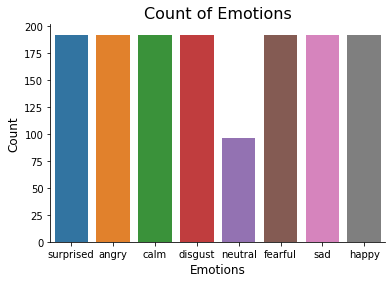

In [ ]:
# Remove unknown emotions from the dataframe
ravdess_df = ravdess_df[ravdess_df.Emotions != 'Unknown']

# Print count of each emotion
plt.title('Count of Emotions', size=16)
sns.countplot(ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
# Visualization
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()    

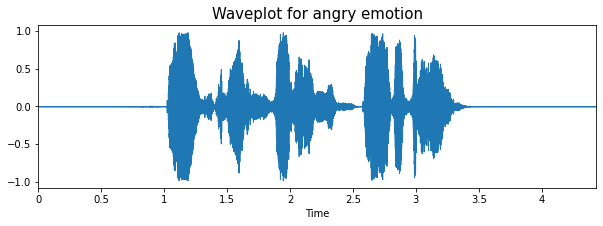

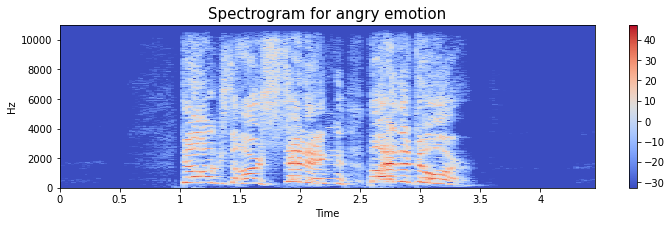

In [ ]:
emotion='angry'
path = "/content/gdrive/MyDrive/Final Project/Audio_Speech_Actors_01-24/Actor_01/03-01-05-02-02-02-01.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
labels = {
    0: 'neutral',
    1: 'calm',
    2: 'happy',
    3: 'sad',
    4: 'angry',
    5: 'fearful',
    6: 'disgust',
    7: 'surprised'
}
ravdess_df.replace({'Emotions':labels},inplace=True)

In [ ]:
import os

data_path = '/content/gdrive/MyDrive/Final Project/Audio_Speech_Actors_01-24/'

file_names = os.listdir(data_path)
print(file_names)

['Actor_21', 'Actor_19', 'Actor_18', 'Actor_24', 'Actor_23', 'Actor_20', 'Actor_22', 'Actor_16', 'Actor_17', 'Actor_10', 'Actor_11', 'Actor_08', 'Actor_12', 'Actor_13', 'Actor_09', 'Actor_14', 'Actor_15', 'Actor_07', 'Actor_06', 'Actor_05', 'Actor_04', 'Actor_02', 'Actor_03', 'Actor_01']


In [ ]:
num_mfcc=13
n_fft=2048
hop_length=512
SAMPLE_RATE = 22050
data = {
        "labels": [],
        "mfcc": []
    }
actors = ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
for actor in actors:
    for filename in os.listdir(f'/content/gdrive/MyDrive/Final Project/Audio_Speech_Actors_01-24/{actor}/'):
        emotion = int(filename.split('-')[2])
        if emotion==1:
          emotion=0
        elif emotion==2:
          emotion=1
        elif emotion==3:
          emotion=2
        elif emotion==4:
          emotion=3
        elif emotion==5:
          emotion=4
        elif emotion==6:
          emotion=5
        elif emotion==7:
          emotion=6
        else:
          emotion=7
        signal, sample_rate = librosa.load(f'/content/gdrive/MyDrive/Final Project/Audio_Speech_Actors_01-24/{actor}/{filename}', sr=SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T
        data["labels"].append(emotion)
        data["mfcc"].append(np.asarray(mfcc))
print("Finished processing data.")


Finished processing data.


In [ ]:
X = np.asarray(data['mfcc'], dtype=object)
y = np.asarray(data["labels"])

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(1440, 228, 13)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)
from keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_validation_cat = to_categorical(y_validation)

In [ ]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(1036, 228, 13) (1036,) (260, 228, 13) (260,) (144, 228, 13) (144,)


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train_cat:", y_train_cat.shape)
print("Shape of X_validation:", X_validation.shape)
print("Shape of y_validation_cat:", y_validation_cat.shape)


Shape of X_train: (1036, 228, 13)
Shape of y_train_cat: (1036, 8)
Shape of X_validation: (260, 228, 13)
Shape of y_validation_cat: (260, 8)


In [ ]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(8, activation='softmax'))
    model.add(Dropout(0.2))
    return model

In [ ]:
# create network
input_shape = (None,13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, None, 128)         72704     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 8)                 520       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
Total params: 126,792
Trainable params: 126,792
Non-tr

In [ ]:
history = model.fit(X_train, y_train_cat, validation_data=(X_validation, y_validation_cat), batch_size=32, epochs=75)
print("Shape of history:", history.history)


Epoch 1/75
33/33 [==============================] - 26s 631ms/step - loss: 4.8032 - accuracy: 0.1593 - val_loss: 1.9327 - val_accuracy: 0.2462
Epoch 2/75
33/33 [==============================] - 19s 568ms/step - loss: 4.6162 - accuracy: 0.2307 - val_loss: 1.8289 - val_accuracy: 0.2692
Epoch 3/75
33/33 [==============================] - 19s 554ms/step - loss: 4.4717 - accuracy: 0.2674 - val_loss: 1.7383 - val_accuracy: 0.3231
Epoch 4/75
33/33 [==============================] - 20s 601ms/step - loss: 4.6252 - accuracy: 0.2674 - val_loss: 1.6927 - val_accuracy: 0.2885
Epoch 5/75
33/33 [==============================] - 20s 613ms/step - loss: 4.6087 - accuracy: 0.3098 - val_loss: 1.6307 - val_accuracy: 0.3615
Epoch 6/75
33/33 [==============================] - 18s 545ms/step - loss: 4.4040 - accuracy: 0.3089 - val_loss: 1.6244 - val_accuracy: 0.3654
Epoch 7/75
33/33 [==============================] - 20s 597ms/step - loss: 4.6372 - accuracy: 0.3301 - val_loss: 1.5695 - val_accuracy: 0.4038

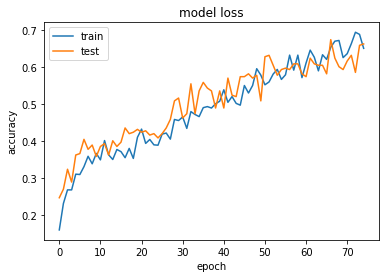

In [ ]:

# Plotting the Train Valid Loss Graph

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
print("Training Accuracy: ",train_acc)


Training Accuracy:  0.8416988253593445


In [ ]:
y_test_cat = to_categorical(y_test)

# Evaluate the model

test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.625


In [ ]:
model.save('Speech-Emotion-Recognition-Model.h5')

In [ ]:
import librosa
import numpy as np
from keras.models import load_model

# Load the model
model = load_model('Speech-Emotion-Recognition-Model.h5')

# Load the audio file
audio_path = '/content/gdrive/MyDrive/Final Project/Audio_Speech_Actors_01-24/Actor_01/03-01-04-02-01-02-01.wav'
signal, sr = librosa.load(audio_path, sr=16000)

# Extract features from the audio file
mfccs = librosa.feature.mfcc(signal, sr=sr, n_mfcc=13)
mfccs_processed = np.mean(mfccs.T,axis=0)

# Reshape the features to match the expected input shape of the model
mfccs_processed = mfccs_processed.reshape(1, -1, 13)

# Predict the class of the audio file
class_idx = np.argmax(model.predict(mfccs_processed), axis=-1)

# Print the predicted class
print('Predicted class:', class_idx)


1/1 [==============================] - 1s 937ms/step
Predicted class: [3]
